
## ME8 Unsupervised Learning

### Clustering

Basic use of common clustering models

- K-means

- DBSCAN

See also Sklearn resources

https://scikit-learn.org/stable/modules/clustering.html

### Set up

In [33]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import seaborn as sn
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN
import sklearn.metrics as metrics

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "clustering_kmeans"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

### Utility functions

In [2]:
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, BoundaryNorm

def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#00AAFF', '#000000', '#FF00AA']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)
    plt.show()

    
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

## K-means model

The K-Means algorithm is one of the fastest clustering algorithms, but also one of the simplest:
* First initialize $k$ centroids randomly: $k$ distinct instances are chosen randomly from the dataset and the centroids are placed at their locations.
* Repeat until convergence (i.e., until the centroids stop moving):
    * Assign each instance to the closest centroid.
    * Update the centroids to be the mean of the instances that are assigned to them.
    
    
The `KMeans` class applies an optimized algorithm by default. To get the original K-Means algorithm (for educational purposes only), you must set `init="random"`, `n_init=1`and `algorithm="full"`. 

See the details of these hyperparameters: 

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

### 1. A synthetic dataset

This example creates a synthetic dataset with make_blobs, then applies k-means to find 3 clusters, and plots the points in each cluster identified by a corresponding color.

#### Generate a dataset

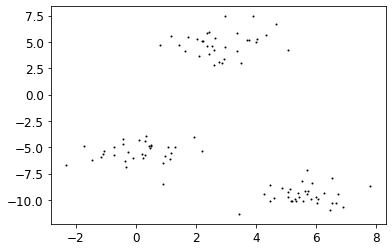

In [3]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state = 10)

plot_data(X)




#### K-means model 

In [4]:
from sklearn.cluster import KMeans

# create a K-means model
kmeans = KMeans(n_clusters=3, init='random', n_init=1, max_iter=10, algorithm='full')


In [5]:
# fit the model
kmeans.fit(X)

C:\Users\seang\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(algorithm='full', init='random', max_iter=10, n_clusters=3, n_init=1)

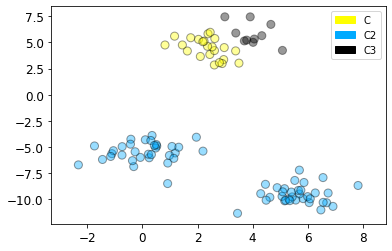

In [6]:
# plot the resulting clusters

plot_labelled_scatter(X, kmeans.labels_, ['C', 'C2', 'C3'])

### 2. Real dataset: Fruit dataset

#### Load the data

A data file: ./data/fruit_data_with_colors.txt

In [7]:
fruits = pd.read_csv('./data/fruit_data_with_colors.txt', sep='\t', engine='python')


fruits.head()

,fruit_label,fruit_name,fruit_subtype,mass,width,height,color_score
0,1,apple,granny_smith,192,8.4,7.3,0.55
1,1,apple,granny_smith,180,8.0,6.8,0.59
2,1,apple,granny_smith,176,7.4,7.2,0.60
3,2,mandarin,mandarin,86,6.2,4.7,0.80
4,2,mandarin,mandarin,84,6.0,4.6,0.79


In [8]:
# Since this dataset already include class labels, we can evaluate the model based on that
# Have X and y

X = fruits[['mass', 'width', 'height', 'color_score']].values
y = fruits[['fruit_label']]-1

print(X)
print(y)

[[192.     8.4    7.3    0.55]
 [180.     8.     6.8    0.59]
 [176.     7.4    7.2    0.6 ]
 [ 86.     6.2    4.7    0.8 ]
 [ 84.     6.     4.6    0.79]
 [ 80.     5.8    4.3    0.77]
 [ 80.     5.9    4.3    0.81]
 [ 76.     5.8    4.     0.81]
 [178.     7.1    7.8    0.92]
 [172.     7.4    7.     0.89]
 [166.     6.9    7.3    0.93]
 [172.     7.1    7.6    0.92]
 [154.     7.     7.1    0.88]
 [164.     7.3    7.7    0.7 ]
 [152.     7.6    7.3    0.69]
 [156.     7.7    7.1    0.69]
 [156.     7.6    7.5    0.67]
 [168.     7.5    7.6    0.73]
 [162.     7.5    7.1    0.83]
 [162.     7.4    7.2    0.85]
 [160.     7.5    7.5    0.86]
 [156.     7.4    7.4    0.84]
 [140.     7.3    7.1    0.87]
 [170.     7.6    7.9    0.88]
 [342.     9.     9.4    0.75]
 [356.     9.2    9.2    0.75]
 [362.     9.6    9.2    0.74]
 [204.     7.5    9.2    0.77]
 [140.     6.7    7.1    0.72]
 [160.     7.     7.4    0.81]
 [158.     7.1    7.5    0.79]
 [210.     7.8    8.     0.82]
 [164.  

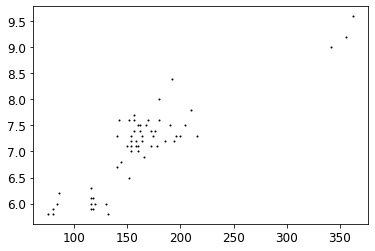

In [9]:
# plot the data (only use 2 attributes, 'mass', 'width')

plot_data(X)

#### Standarizing the data (scaling)

- Note that in general, it's important to scale the individual features before applying k-means clustering.

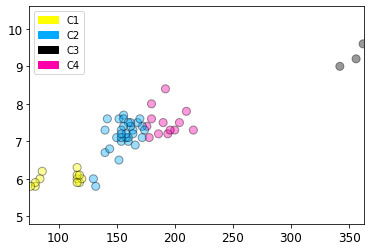

In [10]:
from sklearn.cluster import KMeans

# create a K-means model
# set hyperparameter n_clusters=4, init = 'k-means++' and algorithm = 'elkan'

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=3, max_iter=500, algorithm='elkan')


# fit the model with the data
kmeans.fit(X)

# plot the cluster
plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2', 'C3', 'C4'])

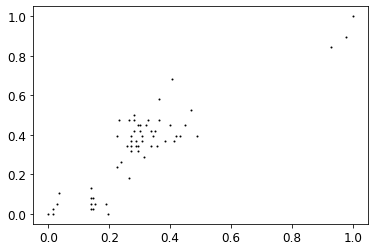

In [11]:
from sklearn.preprocessing import MinMaxScaler

# normalized the data

X_normalized = MinMaxScaler().fit(X).transform(X)

# plot the data

plot_data(X_normalized)

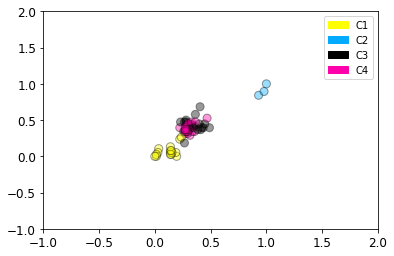

In [12]:
from sklearn.cluster import KMeans

# create a K-means model
# set hyperparameter n_clusters=4, init = 'k-means++' and algorithm = 'elkan'

kmeans = KMeans(n_clusters=4, init='k-means++', n_init=3, max_iter=500, algorithm='elkan')


# fit the model with the data
kmeans.fit(X_normalized)

# plot the cluster
plot_labelled_scatter(X_normalized, kmeans.labels_, ['C1', 'C2', 'C3', 'C4'])

#### K-means model

- This example showing k-means used to find 4 clusters in the fruits dataset.

## k-means vs. DBSCAN clustering

### 1. A simple dataset

#### Generate a dataset

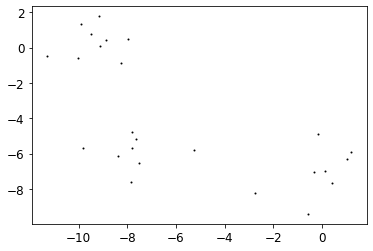

In [13]:
from sklearn.datasets import make_blobs

X, y = make_blobs(random_state = 9, n_samples = 25)

plot_data(X)

#### K-means model

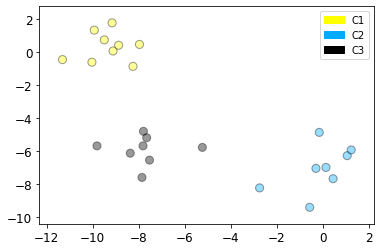

In [14]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2', 'C3'])

#### DBSCAN model

Read the description of the model parameters

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

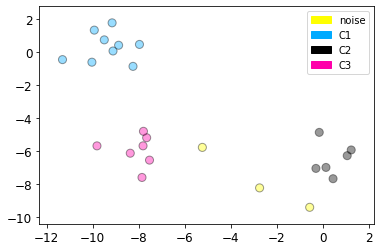

In [15]:
from sklearn.cluster import DBSCAN


dbscan = DBSCAN(eps=2, min_samples=2)
dbscan.fit(X)

plot_labelled_scatter(X, dbscan.labels_+1, ['noise', 'C1', 'C2', 'C3'])

## ME8 Part 1 

### Task 1: The Moon Dataset
#### Apply the following clustering models on a more complex dataset. 

- K-means

- DBSCAN

### A more complicated dataset

#### Generate a synthetic dataset

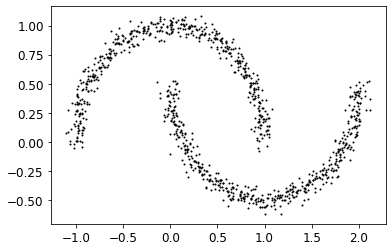

In [16]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=1000, noise=0.05, random_state=42)

plot_data(X)

#### (1) K-means model


- Apply k-means model

- use k = 2

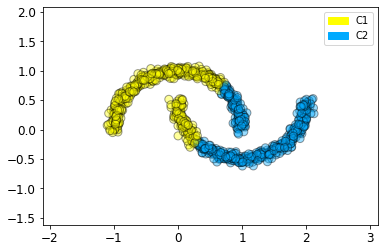

In [17]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(X)

plot_labelled_scatter(X, kmeans.labels_, ['C1', 'C2'])

#### (2) DBSCAN model

- Apply DBSCAN model

- use eps=0.2, min_samples=5

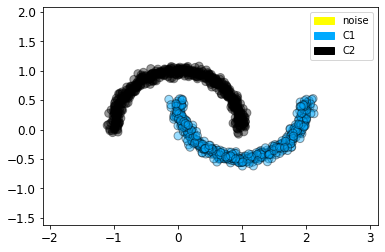

In [18]:
dbscan = DBSCAN(eps=.2, min_samples=5)
dbscan.fit(X)

plot_labelled_scatter(X, dbscan.labels_+1, ['noise', 'C1', 'C2'])

### Task 2: The Breast Cancer Dataset
#### Apply k-means model on breast cancer dataset and check the model performance

- check also notebook, clustering_Kmeans.ipynb for implementation details of k-means model

#### (1) load the data

- load breat cancer dataset from sklearn.datasets (set the parameter, return_X_y = True)

- print the first five X values

- print the first five y values

In [23]:
# Breast cancer dataset for classification
from sklearn.datasets import load_breast_cancer

X_cancer, y_cancer = load_breast_cancer(return_X_y = True)

print(X_cancer[:5])
print(y_cancer[:5])

[[1.799e+01 1.038e+01 1.228e+02 1.001e+03 1.184e-01 2.776e-01 3.001e-01
  1.471e-01 2.419e-01 7.871e-02 1.095e+00 9.053e-01 8.589e+00 1.534e+02
  6.399e-03 4.904e-02 5.373e-02 1.587e-02 3.003e-02 6.193e-03 2.538e+01
  1.733e+01 1.846e+02 2.019e+03 1.622e-01 6.656e-01 7.119e-01 2.654e-01
  4.601e-01 1.189e-01]
 [2.057e+01 1.777e+01 1.329e+02 1.326e+03 8.474e-02 7.864e-02 8.690e-02
  7.017e-02 1.812e-01 5.667e-02 5.435e-01 7.339e-01 3.398e+00 7.408e+01
  5.225e-03 1.308e-02 1.860e-02 1.340e-02 1.389e-02 3.532e-03 2.499e+01
  2.341e+01 1.588e+02 1.956e+03 1.238e-01 1.866e-01 2.416e-01 1.860e-01
  2.750e-01 8.902e-02]
 [1.969e+01 2.125e+01 1.300e+02 1.203e+03 1.096e-01 1.599e-01 1.974e-01
  1.279e-01 2.069e-01 5.999e-02 7.456e-01 7.869e-01 4.585e+00 9.403e+01
  6.150e-03 4.006e-02 3.832e-02 2.058e-02 2.250e-02 4.571e-03 2.357e+01
  2.553e+01 1.525e+02 1.709e+03 1.444e-01 4.245e-01 4.504e-01 2.430e-01
  3.613e-01 8.758e-02]
 [1.142e+01 2.038e+01 7.758e+01 3.861e+02 1.425e-01 2.839e-01 2.414

#### (2) scaling the data

- scale X values using MinMaxScaler()

- print the normalized (scaled) values of the first five X

In [20]:
# normalized the data
X_cancer_normalized = MinMaxScaler().fit(X_cancer).transform(X_cancer)
print(X_cancer_normalized[:5])

[[0.52103744 0.0226581  0.54598853 0.36373277 0.59375282 0.7920373
  0.70313964 0.73111332 0.68636364 0.60551811 0.35614702 0.12046941
  0.3690336  0.27381126 0.15929565 0.35139844 0.13568182 0.30062512
  0.31164518 0.18304244 0.62077552 0.14152452 0.66831017 0.45069799
  0.60113584 0.61929156 0.56861022 0.91202749 0.59846245 0.41886396]
 [0.64314449 0.27257355 0.61578329 0.50159067 0.28987993 0.18176799
  0.20360825 0.34875746 0.37979798 0.14132266 0.15643672 0.08258929
  0.12444047 0.12565979 0.11938675 0.08132304 0.0469697  0.25383595
  0.08453875 0.0911101  0.60690146 0.30357143 0.53981772 0.43521431
  0.34755332 0.15456336 0.19297125 0.63917526 0.23358959 0.22287813]
 [0.60149557 0.3902604  0.59574321 0.44941676 0.51430893 0.4310165
  0.46251172 0.63568588 0.50959596 0.21124684 0.22962158 0.09430251
  0.18037035 0.16292179 0.15083115 0.2839547  0.09676768 0.38984656
  0.20569032 0.12700551 0.55638563 0.36007463 0.50844166 0.37450845
  0.48358978 0.38537513 0.35974441 0.83505155 0.

#### (3) K-means model

- Apply k-means model with k = 2

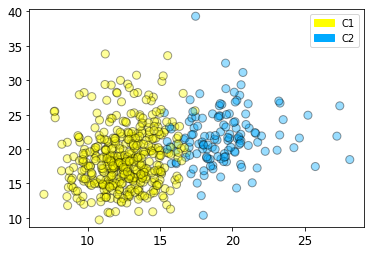

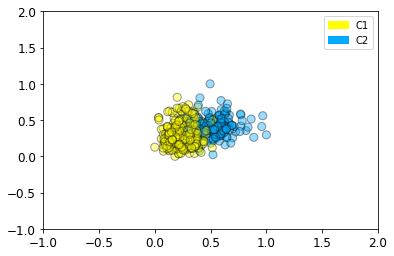

In [21]:
kmeans = KMeans(n_clusters=2)

kmeans.fit(X_cancer)
plot_labelled_scatter(X_cancer, kmeans.labels_, ['C1', 'C2'])

kmeans.fit(X_cancer_normalized)
plot_labelled_scatter(X_cancer_normalized, kmeans.labels_, ['C1', 'C2'])

#### (4) Evaluate Model performance of K-means

##### evaluation method 1:

- print the sum of all correctly predicted data (y_predicted==y_cancer)

- Since we have y_cancer values, we compare the predicted value to its y_cancer value. The ratio of correctly predicted class can represent the accuracy of the model. 


##### evaluaton method 2:

- calculate Silhouette scores (examples are given in cluster_eval.ipynb)

In [31]:
# Evaluation method 1
X_train, X_test, y_train, y_test = train_test_split(X_cancer_normalized, y_cancer, random_state=0)
y_pred = kmeans.predict(X_test)
print(accuracy_score(y_test, y_pred))

sum = 0
for test, pred, in zip(y_test, y_pred):
    if(test == pred):
        sum += 1   
print(sum)

0.04895104895104895
7


In [36]:
# Evaluation method 2

k_values = np.arange(2, 10)

# k is the number of clusters
# iterate through a range of k values and find the best
for k in k_values:
    # Train the model
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=10)
    kmeans.fit(X_train)
    
    # extract performance metrics
    score = metrics.silhouette_score(X_train, kmeans.labels_, 
                metric='euclidean', sample_size=len(X_train))

    print('\n k = {:} --> Silhouette score = {:.4f}'.format(k, score))


 k = 2 --> Silhouette score = 0.3878

 k = 3 --> Silhouette score = 0.3391

 k = 4 --> Silhouette score = 0.3239

 k = 5 --> Silhouette score = 0.1691

 k = 6 --> Silhouette score = 0.1598

 k = 7 --> Silhouette score = 0.1634

 k = 8 --> Silhouette score = 0.1566

 k = 9 --> Silhouette score = 0.1585


#### (5) Optimal parameters of clustering models

Pleae check the examples of k-means and DBSCAN models in the following notebook (available on ME8 assignment page) and find out optimal parameters of each of the algorithms for the given dataset. 

- clustering_Kmeans.ipynb

- clustering_DBSCAN.ipynb


## Part 2

- Upload the notebook on GitHub

- Submit a summary of your learning to Canvas. Your document should include:
    - Full names of your team members who work on the assignment.
    - URL links to the notebook of each student on GitHub repo. 
    - A summary of what you learned from the teamwork assignment. 